In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
dataset_path = '/Users/pro/Desktop/voiceRec/data_speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'forward', 'off', 'four']


In [3]:
# Settings
feature_sets_path = '/Users/pro/Desktop/voiceRec'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape) #77534: Total number of words , Number of MFCC coefficients computed for each frame , Number of frames per word
print(x_val.shape)   #
print(x_test.shape)  #

(77534, 16, 16)
(9645, 16, 16)
(9677, 16, 16)


In [7]:
# Peek at labels
print(y_val)

[15. 33. 33. ...  2. 33.  8.]


In [8]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [9]:
# Peek at labels after conversion
print(y_val)

[1. 0. 0. ... 0. 0. 0.]


In [10]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.03608087091757387
0.9639191290824262


In [11]:
# View the dimensions of our input data
print(x_train.shape)

(77534, 16, 16)


In [12]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77534, 16, 16, 1)
(9645, 16, 16, 1)
(9677, 16, 16, 1)


In [13]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [14]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

In [16]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [17]:
history = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=100,
    validation_data=(x_val, y_val),
)

Epoch 1/30


2024-11-01 00:42:36.642653: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


776/776 [==============================] - 3s 4ms/step - loss: 0.1150 - acc: 0.9663 - val_loss: 0.0747 - val_acc: 0.9777
Epoch 2/30
776/776 [==============================] - 3s 4ms/step - loss: 0.0736 - acc: 0.9774 - val_loss: 0.0606 - val_acc: 0.9818
Epoch 3/30
776/776 [==============================] - 3s 4ms/step - loss: 0.0617 - acc: 0.9810 - val_loss: 0.0542 - val_acc: 0.9821
Epoch 4/30
776/776 [==============================] - 3s 4ms/step - loss: 0.0555 - acc: 0.9833 - val_loss: 0.0799 - val_acc: 0.9802
Epoch 5/30
776/776 [==============================] - 3s 4ms/step - loss: 0.0525 - acc: 0.9840 - val_loss: 0.1083 - val_acc: 0.9611
Epoch 6/30
776/776 [==============================] - 3s 4ms/step - loss: 0.0532 - acc: 0.9849 - val_loss: 0.0492 - val_acc: 0.9857
Epoch 7/30
776/776 [==============================] - 3s 4ms/step - loss: 0.0526 - acc: 0.9849 - val_loss: 0.0663 - val_acc: 0.9851
Epoch 8/30
776/776 [==============================] - 4s 5ms/step - loss: 0.0550 - acc:

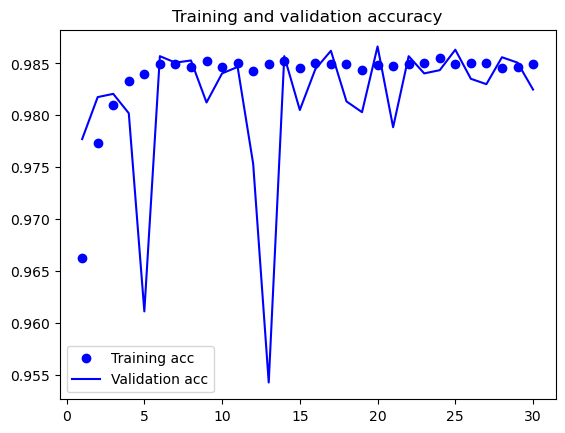

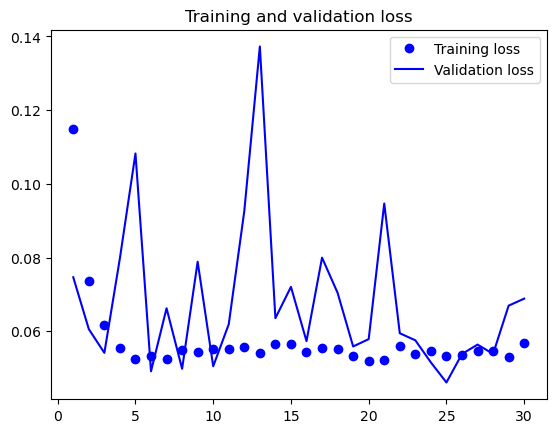

In [18]:

# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Save the model as a file
models.save_model(model, model_filename)

In [23]:
# Save the model as a file
model_filename1 = '/Users/pro/Desktop/voiceRec/wake_word_stop_model.h5'

models.save_model(model, model_filename1)


In [20]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

31
36
46
63
93
109
110
198
205
283
333
361
370
377
429
461
471
488
503
520
543
548
619
673
702
725
736
766
817
876
883
945
966
999
1095
1113
1117
1143
1149
1160
1186
1195
1213
1220
1225
1229
1230
1257
1259
1265
1272
1517
1540
1545
1583
1598
1689
1731
1736
1739
1783
1810
1876
1889
1896
1905
1999
2009
2037
2072
2086
2111
2160
2186
2190
2200
2229
2240
2245
2274
2331
2340
2398
2401
2439
2440
2442
2445
2451
2461
2496
2497
2521
2539
2540
2545
2557
2559
2619
2652
2653
2659
2666
2709
2727
2737
2770
2792
2803
2829
2840
2928
2931
2944
2961
2992
3008
3022
3027
3028
3033
3050
3055
3098
3149
3152
3167
3198
3208
3229
3233
3315
3416
3465
3479
3518
3532
3603
3606
3627
3659
3701
3714
3917
3926
3997
4000
4029
4064
4097
4156
4174
4202
4205
4212
4253
4261
4353
4386
4393
4411
4419
4430
4473
4474
4518
4530
4656
4677
4700
4708
4734
4772
4832
4842
4865
4872
4875
4969
5014
5067
5075
5107
5113
5118
5166
5220
5254
5311
5312
5324
5345
5377
5396
5427
5447
5474
5497
5525
5587
5590
5628
5647
5657
5673
5731
5743
5763

In [21]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 39ms/step
Answer: 0.0  Prediction: [[0.0006655]]
1/1 [==============================] - 0s 9ms/step
Answer: 0.0  Prediction: [[2.0467765e-16]]
1/1 [==============================] - 0s 8ms/step
Answer: 0.0  Prediction: [[1.10068704e-10]]
1/1 [==============================] - 0s 9ms/step
Answer: 0.0  Prediction: [[0.00043177]]
1/1 [==============================] - 0s 8ms/step
Answer: 0.0  Prediction: [[0.03094363]]
1/1 [==============================] - 0s 8ms/step
Answer: 0.0  Prediction: [[4.8726287e-11]]
1/1 [==============================] - 0s 8ms/step
Answer: 0.0  Prediction: [[1.7468357e-06]]
1/1 [==============================] - 0s 8ms/step
Answer: 0.0  Prediction: [[1.9234074e-06]]
1/1 [==============================] - 0s 8ms/step
Answer: 0.0  Prediction: [[0.24521056]]
1/1 [==============================] - 0s 8ms/step
Answer: 1.0  Prediction: [[0.9999976]]


In [22]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 0s 1ms/step - loss: 0.0794 - acc: 0.9834


[0.07938062399625778, 0.98336261510849]

In [24]:
import tensorflow as tf
print(tf.__version__)


2.12.0
